# Occasionally binding constraint model - Solved with Adaptive Sparse Grids (Julia)

This notebook solves the Bianchi (2011) model with occasionally binding collateral constraints using Adaptive Sparse Grids

## Setup and Calibration

In [2]:
using AdaptiveSparseGrids
using Roots
using Plots
using LaTeXStrings
using StatsPlots
using LinearAlgebra
using Random
using QuantEcon
using Statistics

cd(dirname(@__FILE__))

# ============================================================================ #
#                                  CALIBRATION                                 #
# ============================================================================ #

"""
Bianchi (2011) sudden stops model solved with Adaptive Sparse Grids.
The shock process is now on the traded-good endowment yT.
"""

# --------------------------- Structural parameters -------------------------- #
σ       = 2           # Inverse of intertemporal elasticity of consumption
κ       = .2808      # Parameter in borrowing constraint
β       = 0.91        # Subjective discount factor
ω       = 0.31        # Weight on traded goods in CES aggregator
η       = 0.5         # Elasticity of substitution between traded/non-traded goods

# ----------------------------- State variables ------------------------------ #
yN      = 1.0         # Endowment of non-traded goods (constant)
τ       = 0.2         # Tax rate

# Interest rate
i_l     = 0.05

# Stochastic Income Process (yT)
yT_size = 21         # Grid size for income
ρy      = 0.945      # Persistence in the income process
ηy      = 0.025      # Standard deviation of the income process

# Loans bounds
l_min = 0.1
l_max = 0.85

# Discretize the income process using Tauchen
mc = tauchen(yT_size, ρy, ηy,0.,1.5)
yT_grid = exp.(mc.state_values)
Π = mc.p
n_s = yT_size # Number of shock states is the size of the income grid

# Bounds for ASG: [l, shock_index]


21

## Utility Functions

In [3]:
# We'll treat shock_index as continuous between 1 and n_s for ASG purposes
lower_bound = [l_min, 1.0]
upper_bound = [l_max, Float64(n_s)]

# ============================================================================ #
#                              UTILITY FUNCTIONS                               #
# ============================================================================ #

# Marginal utility of traded consumption
∂u∂cT(ct, yn; ξ=η, a=ω) = ct > 0. ?
    a * ct^(-1/ξ) * (a*ct^((ξ-1)/ξ) + (1-a)*yn^((ξ-1)/ξ))^((1-σ*ξ)/(ξ-1)) :
    999_999.

# Price of non-traded goods
price_nontrade(ct, yn; ξ=η, a=ω) = (1-a)/a * (ct/yn)^(1/ξ)

# Borrowing constraint, now dependent on the yT state
borr_constraint(pn, yT_val) = κ * (pn * yN + yT_val * (1-τ))

# ============================================================================ #
#                            HELPER FUNCTIONS FOR ASG                          #
# ============================================================================ #


borr_constraint (generic function with 1 method)

## ASG Helper Functions

In [4]:

"""
Extract sparse grid points from AdaptiveSparseGrid object.
Returns matrix with rows = observations, columns = dimensions
"""
function extract_grid(fun)
    nb_dim = length(fun.nodes[first(keys(fun.nodes))].x)
    grid = zeros(length(keys(fun.nodes)), nb_dim)

    for (index_key, key) in enumerate(keys(fun.nodes))
        for i = 1:nb_dim
            grid[index_key, i] = fun.nodes[key].x[i]
        end
    end

    # Rescale from [0,1] to actual bounds
    grid = transpose(fun.bounds[:, 1] .+ transpose(grid) .* (fun.bounds[:,2] - fun.bounds[:,1]))

    return grid
end

"""
Get shock variables for a given continuous shock index
"""
function get_shock_state(s_idx)
    # Clamp and convert to discrete index
    s_int = clamp(Int(round(s_idx)), 1, n_s)
    yT_val = yT_grid[s_int]
    return yT_val, s_int
end


get_shock_state

## Initial Guess Function

In [5]:

"""
Compute expected marginal utility E[λ(l', s')|s]
"""
function expected_lambda(lp, s_idx, fun_LP)
    _, s_int = get_shock_state(s_idx)

    E_lambda = 0.0
    for sp in 1:n_s
        # Next period loan choice
        lpp = clamp(fun_LP([lp, Float64(sp)]), l_min, l_max)

        # Next period consumption
        yTp, _ = get_shock_state(Float64(sp))
        # Consumption in the next period (note: phi shock is removed)
        ctp = max(yTp*(1-τ) - lp + lpp/(1+i_l), 1e-15)

        # Marginal utility
        λp = ∂u∂cT(ctp, yN)

        # Expected value
        E_lambda += Π[s_int, sp] * λp
    end

    return E_lambda
end

# ============================================================================ #
#                         POLICY FUNCTION ITERATION                            #
# ============================================================================ #

"""
Initial guess for policy function: LP(l, s) = l (no change)
"""
function init_guess(x)
    l = x[1]
    s_idx = x[2]

    yT_val, _ = get_shock_state(s_idx)
    # Consumption calculation no longer includes phi
    ct = yT_val*(1-τ) - l + l/(1+i_l)
    ct <= 0 && return l_min

    pn = price_nontrade(ct, yN)
    bc = borr_constraint(pn, yT_val)

    return min(l, bc)
end


init_guess

## Policy Iteration RHS

In [6]:
"""
Right-hand side of policy function iteration:
Solve for LP(l,s) using Euler equation and borrowing constraint
"""
function RHS_policy(x, fun_LP_old)
    l = x[1]
    s_idx = x[2]
    yT_val, s_int = get_shock_state(s_idx)

    # Define residual function for root finding
    function euler_residual(lp)
        lp_bounded = clamp(lp, l_min, l_max)

        # Current consumption (no longer includes phi)
        ct = max(yT_val*(1-τ) - l + lp_bounded/(1+i_l), 1e-15)

        # Current price and borrowing constraint
        pn = price_nontrade(ct, yN)
        bc = borr_constraint(pn, yT_val)

        # Expected marginal utility
        E_λ = expected_lambda(lp_bounded, s_idx, fun_LP_old)

        # Euler equation residual
        euler_res = ∂u∂cT(ct, yN)/(1+i_l) - β * E_λ

        # Constraint slack
        constraint_slack = bc - lp_bounded

        # Fischer-Burmeister function
        return euler_res + constraint_slack - sqrt(euler_res^2 + constraint_slack^2 + 1e-9)
    end

    # Solve for optimal lp
    try
        # Initial guess: previous policy
        lp_guess = fun_LP_old(x)
        lp_opt = fzero(euler_residual, lp_guess)
        return clamp(lp_opt, l_min, l_max)
    catch
        # Fallback: evaluate on grid and pick minimum
        l_test = range(l_min, l_max, length=20)
        res_vals = [abs(euler_residual(lt)) for lt in l_test]
        _, min_idx = findmin(res_vals)
        return l_test[min_idx]
    end
end


RHS_policy

## Model Solver

In [7]:

# ============================================================================ #
#                              SOLVE THE MODEL                                 #
# ============================================================================ #

function solve_model()
    println("\n" * "="^70)
    println("Solving Bianchi model with Adaptive Sparse Grids (Julia)")
    println("="^70)

    # ASG parameters
    max_depth = 7          # Maximum depth of basis elements
    tol_asg = 0.002        # Tolerance for adding nodes
    tol_vfi = 1e-6         # Convergence tolerance for VFI
    max_iter = 200         # Maximum iterations

    # Initialize policy function
    println("\nInitializing policy function...")
    start_init = time()
    fun_LP = AdaptiveSparseGrid(init_guess, lower_bound, upper_bound,
                                max_depth = max_depth,
                                tol = tol_asg)
    init_time = time() - start_init

    println("Initial grid points: $(length(fun_LP.nodes))")
    println("Initialization time: $(round(init_time, digits=2))s")

    # Extract initial grid for convergence check
    xy_grid = extract_grid(fun_LP)
    pred_old = [fun_LP(xy_grid[i,:]) for i in 1:size(xy_grid,1)]

    # Main iteration loop
    fun_LP_old = deepcopy(fun_LP)

    println("\nStarting policy function iteration...")
    println("-"^70)

    start_time = time()
    for iter in 1:max_iter
        iter_start = time()

        # Update policy function using ASG
        fun_LP = AdaptiveSparseGrid(x -> RHS_policy(x, fun_LP_old),
                                    lower_bound, upper_bound,
                                    max_depth = max_depth,
                                    tol = tol_asg)

        # Check convergence on fixed grid
        pred_new = [fun_LP(xy_grid[i,:]) for i in 1:size(xy_grid,1)]
        diff = maximum(abs.(pred_new .- pred_old))

        iter_time = time() - iter_start
        elapsed = time() - start_time

        println("Iter: $iter | Diff: $(round(diff, digits=8)) | Grid points: $(length(fun_LP.nodes)) | Iter time: $(round(iter_time, digits=2))s | Total: $(round(elapsed, digits=1))s")

        # Check convergence
        if diff < tol_vfi
            println("-"^70)
            println("✓ Convergence reached at iteration $iter")
            println("  Final difference: $(round(diff, digits=10))")
            println("  Final grid points: $(length(fun_LP.nodes))")
            println("  Total time: $(round(elapsed, digits=2))s")
            break
        end

        if iter == max_iter
            println("-"^70)
            println("⚠ Maximum iterations reached without convergence")
            println("  Final difference: $(round(diff, digits=10))")
            println("  Total time: $(round(elapsed, digits=2))s")
        end

        # Update for next iteration
        pred_old = copy(pred_new)
        fun_LP_old = deepcopy(fun_LP)
    end

    return fun_LP
end

# Run solver
fun_LP = solve_model()



Solving Bianchi model with Adaptive Sparse Grids (Julia)

Initializing policy function...
Initial grid points: 810
Initialization time: 3.08s

Starting policy function iteration...
----------------------------------------------------------------------
Iter: 1 | Diff: 0.37430493 | Grid points: 1038 | Iter time: 2.47s | Total: 2.5s
Iter: 2 | Diff: 0.02301379 | Grid points: 1037 | Iter time: 0.3s | Total: 2.8s
Iter: 3 | Diff: 0.02120839 | Grid points: 1037 | Iter time: 0.27s | Total: 3.1s
Iter: 4 | Diff: 0.01990481 | Grid points: 1042 | Iter time: 0.25s | Total: 3.3s
Iter: 5 | Diff: 0.0190673 | Grid points: 1045 | Iter time: 0.25s | Total: 3.6s
Iter: 6 | Diff: 0.01619496 | Grid points: 1045 | Iter time: 0.23s | Total: 3.8s
Iter: 7 | Diff: 0.01285487 | Grid points: 1025 | Iter time: 0.21s | Total: 4.0s
Iter: 8 | Diff: 0.01007754 | Grid points: 1025 | Iter time: 0.21s | Total: 4.2s
Iter: 9 | Diff: 0.00411737 | Grid points: 1025 | Iter time: 0.19s | Total: 4.4s
Iter: 10 | Diff: 0.00082971 |

Sparse Adaptive Function Representation: R^2 → R^1
    nodes: 1025
    depth: 7
    domain: [0.1 0.85; 1.0 21.0]


## Visualization


Generating plots...

✓ Model solved successfully!



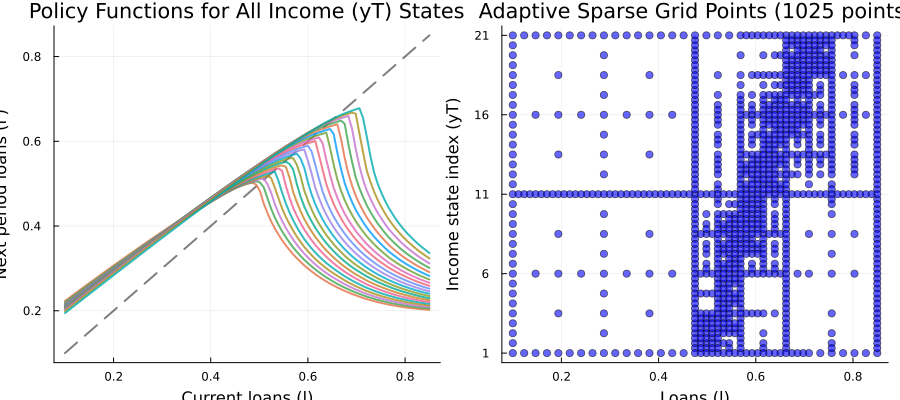

In [8]:

# ============================================================================ #
#                              VISUALIZATION                                   #
# ============================================================================ #

println("\n" * "="^70)
println("Generating plots...")
println("="^70)

# Create fine grid for plotting
n_plot = 100
l_plot = range(l_min, l_max, length=n_plot)

# ---------------------- Plot 1: All policies together ----------------------- #
p1 = plot(xlabel="Current loans (l)",
          ylabel="Next period loans (l')",
          title="Policy Functions for All Income (yT) States",
          legend=false,
          size=(700, 500))

# Plot 45-degree line
plot!(p1, l_plot, l_plot, linestyle=:dash, color=:black,
      linewidth=2, alpha=0.5)

# Plot policy for each shock state
for s in 1:n_s
    LP_vals = [fun_LP([l, Float64(s)]) for l in l_plot]
    plot!(p1, l_plot, LP_vals,
          linewidth=2,
          alpha=0.8)
end

# ------------------- Plot 2: Adaptive sparse grid points -------------------- #
# Extract grid points from ASG
xy_grid_final = extract_grid(fun_LP)

p2 = scatter(xy_grid_final[:, 1], xy_grid_final[:, 2],
             xlabel="Loans (l)",
             ylabel="Income state index (yT)",
             title="Adaptive Sparse Grid Points ($(length(fun_LP.nodes)) points)",
             markersize=4,
             alpha=0.6,
             legend=false,
             size=(700, 500),
             color=:blue,
             yticks = (1:5:n_s))


println("\n✓ Model solved successfully!")
println("="^70 * "\n")


plot(p1,p2,layout=(1,2),size=(900,400))
